# Natural Language Processing with Disaster Tweets

## Albina Jetybayeva. DSE511

The task for DSE511 Project 2 is to use the Kaggle Disaster Tweets dataset, available at https://www.kaggle.com/c/nlp-getting-started. This dataset is composed of tweets that may or may not be about disasters. There are two csv files, train.csv (~ 8500 samples) and test.csv (~3500 samples) -- for this project only train.csv will be used since test.csv doesn't include ground truth labels. Each tweet in train.csv has been hand-annotated to indicate if it is about a real disaster (1) or not (0). For more info, see https://www.kaggle.com/c/nlp-getting-started/data

The assignment is to build a ML pipeline on this dataset. Given the text of a tweet (and any other features), it is required to train an ML classifer that predicts whether the tweet is about a real disaster or not. The pipeline would contain feature extraction, a comparison of 3 different ML approaches (Logistic Regression as a baseline), hyperparameter optimization, model evaluation, and some basic error analysis. For evaluation, report precision, recall, and F1 scores on the test set would be provided. Also the training times and prediction times of the different ML approaches will be compared.

## Data analysis with infographics. Exploratory data analysis.

First, the data will be represented and analysed with the inforgaphics to understand what is the nature of data and choose the right approach of analysis.

In [1]:
#Import the basic important libraries
import numpy as np
import pandas as pd

In [2]:
#Extract data from the file:
data = pd.read_csv('train.csv')
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
print('There are {} rows and {} columns in train'.format(data.shape[0],data.shape[1]))

There are 7613 rows and 5 columns in train


In [4]:
# drop id, keyword, and location columns for train datasets as only tweet text will be used
cols_to_drop = ["id", "keyword", "location"]
data_train = data.drop(cols_to_drop, axis=1)

data_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
#First, basic preprocessing will be done with the removal of hyperlinks, punctuation, non-ascii, numbers

import re
import string
def preprocess(text):

    text=text.lower()
    #Remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #Remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #Remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #Remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    #Remove numbers
    text=re.sub(r'\d+', '', text)
    text=" ".join(text.split())
    return text
data1=data_train
data1['text'] = data1['text'].apply(preprocess)
data_processed = data1
data_processed.head()
data_processed


,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la ronge sask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in ...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,the out of control wild fires in california ev...,1
7610,m utckm s of volcano hawaii,1
7611,police investigating after an ebike collided w...,1


In [6]:
# Import important librarires to remove the stopwords, which do not bring a lot of meaing to the analysis
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
#Apply the stopwords removal:

stop = stopwords.words('english')
data_processed['tweet_without_stopwords'] = data_processed['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_processed

,text,target,tweet_without_stopwords
0,our deeds are the reason of this earthquake ma...,1,deeds reason earthquake may allah forgive us
1,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...,1,residents asked shelter place notified officer...
3,people receive wildfires evacuation orders in ...,1,people receive wildfires evacuation orders cal...
4,just got sent this photo from ruby alaska as s...,1,got sent photo ruby alaska smoke wildfires pou...
...,...,...,...
7608,two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...
7609,the out of control wild fires in california ev...,1,control wild fires california even northern pa...
7610,m utckm s of volcano hawaii,1,utckm volcano hawaii
7611,police investigating after an ebike collided w...,1,police investigating ebike collided car little...


In [8]:
# Import important librarires and apply to lemmatize the text for the easier analysis:

nltk.download('wordnet')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

data_processed['text_lemmatized'] = data_processed.tweet_without_stopwords.apply(lemmatize_text)
data_processed['text_lemmatized'] = data_processed['text_lemmatized'].apply(lambda x: " ".join(x)) #convert list to one string

data_processed


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,target,tweet_without_stopwords,text_lemmatized
0,our deeds are the reason of this earthquake ma...,1,deeds reason earthquake may allah forgive us,deed reason earthquake may allah forgive u
1,forest fire near la ronge sask canada,1,forest fire near la ronge sask canada,forest fire near la ronge sask canada
2,all residents asked to shelter in place are be...,1,residents asked shelter place notified officer...,resident asked shelter place notified officer ...
3,people receive wildfires evacuation orders in ...,1,people receive wildfires evacuation orders cal...,people receive wildfire evacuation order calif...
4,just got sent this photo from ruby alaska as s...,1,got sent photo ruby alaska smoke wildfires pou...,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...
7608,two giant cranes holding a bridge collapse int...,1,two giant cranes holding bridge collapse nearb...,two giant crane holding bridge collapse nearby...
7609,the out of control wild fires in california ev...,1,control wild fires california even northern pa...,control wild fire california even northern par...
7610,m utckm s of volcano hawaii,1,utckm volcano hawaii,utckm volcano hawaii
7611,police investigating after an ebike collided w...,1,police investigating ebike collided car little...,police investigating ebike collided car little...


## Bag of words

To convert data into a numerical vector use Bag of Words first.

In [9]:
#Import the needed libraries
from nltk import word_tokenize
nltk.download('punkt')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# create bag of word representation of the text data
bow_vectorizer = CountVectorizer(dtype=np.float32,
                                 strip_accents='unicode',
                                 tokenizer=word_tokenize,
                                 ngram_range=(1,1), # keep the unigram
                                 analyzer='word', # feature should be made of word n-gram
                                 min_df=10, # ignore terms appeared less than 10 times
                                 max_df=0.75) # ignore terms appeared more than 75% of the tweets available

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
bow_features = pd.DataFrame(bow_vectorizer.fit_transform(data_processed['text_lemmatized']).toarray(), columns=sorted(bow_vectorizer.vocabulary_))
bow_features

,aba,abc,ablaze,able,absolutely,accident,according,account,across,act,...,yo,york,youll,young,youre,youth,youtube,youve,yr,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Inforgraphics

In [11]:
#To visualize the most frequently used words the wordcloud function will be used. Import its libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [12]:
#Create index arrays for filtering rows based on the target
disaster_text_row_index = data_processed.query("target == 1").index
non_disaster_text_row_index = data_processed.query("target == 0").index

In [13]:
#Create a dictionary of term frequency
def create_term_frequency_count(term_features):
    word_count = term_features.sum()
    return dict(zip(word_count.index, word_count.values))

#Function for create wordcloud from term frequency dictionary
def create_word_cloud(category_count, title=""):
    wordcloud = WordCloud(background_color="black",
                          random_state=1, # reproducible wordcloud
                          width=1600, 
                          height=800).generate_from_frequencies(category_count)
    plt.figure(figsize=(10,10));
    plt.imshow(wordcloud)
    plt.title(label=title, fontdict={"fontsize": 30})
    plt.axis("off")
    plt.show();

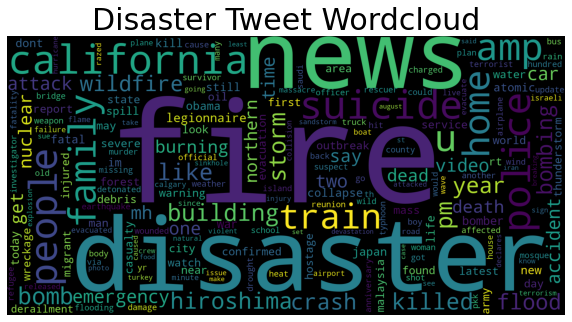

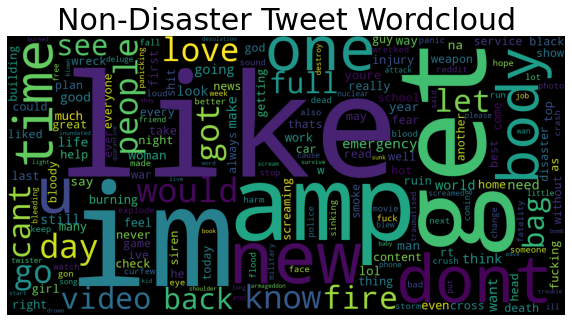

In [14]:
#Create term frequency dictionary and use it for plotting the word cloud
category_count = create_term_frequency_count(bow_features.iloc[disaster_text_row_index])
create_word_cloud(category_count, title="Disaster Tweet Wordcloud")


category_count = create_term_frequency_count(bow_features.iloc[non_disaster_text_row_index])
create_word_cloud(category_count, title="Non-Disaster Tweet Wordcloud")

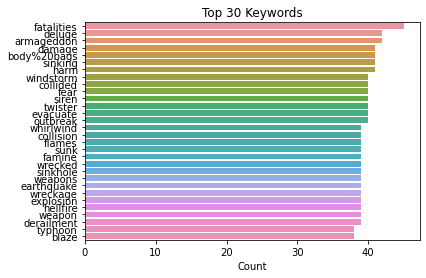

In [15]:
#To analyze the keywords in the tweets, their frequency will be also plotted
import seaborn as sns
keywords_vc = pd.DataFrame({"Count": data["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:30].index, x=keywords_vc[0:30]["Count"], orient='h')
plt.title("Top 30 Keywords")
plt.show()

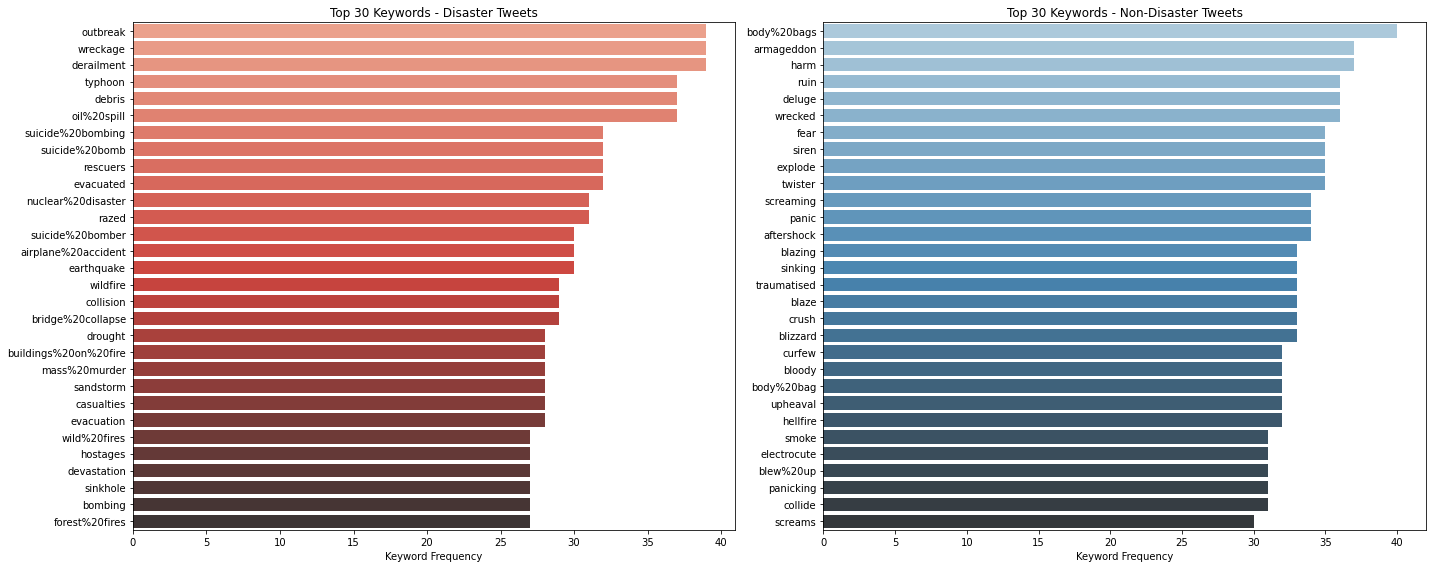

In [16]:
#Now compare the keywords from disasters tweets and non-disaster tweets

disaster_keywords = data.loc[data["target"] == 1]["keyword"].value_counts()
nondisaster_keywords = data.loc[data["target"] == 0]["keyword"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_keywords[0:30].index, x=disaster_keywords[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_keywords[0:30].index, x=nondisaster_keywords[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Keywords - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Keywords - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

## Summary

* It can be clearly seen from the wordcloud that for disaster tweets such words as "fire", "disaster", "kill", "suicide", "bomb", etc. are predominant, which is reasonable.
* For non-disaster tweets instead, general words such as "like", "time", "get", "new", etc. are prevailing. 
* Special attention is to the word "amp" popular in the non-disaster tweets. It will be discussed at the last section of the analysis.
* In the top 30 keywords the disaster related words such as "fatalities", "deluge", "armageddon, "damage", etc, are mainly observed.
* The top 5 keywords in the disaster tweets include: outbreak, wreckage, derailment, typhoon,debris.
* The top 5 keywords in the non-disaster tweets inlucde: body%20bags, armageddon, harm, ruin, deluge. These are very close in their meaning to the disaster cases, so it would be difficult to differentiate the disaster - non-disaster cases just based on the keywords.
* Thus, analysis will be based on tweets texts.